<a href="https://colab.research.google.com/github/herysedra/ady_cov/blob/master/scr%5Cmodely_RP%5CR_antana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install pynverse

  Created wheel for pynverse: filename=pynverse-0.1.4.4-cp36-none-any.whl size=6350 sha256=c5f7506a3612fc7bc505a9857dcd927fe2e0c45af41efee75a5016908f7dc12f
  Stored in directory: /root/.cache/pip/wheels/80/ab/86/ec93f37613f012ba3e65c2bbd67e5c54cbc00d237574100c24
Successfully built pynverse


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

import datetime
import time
from datetime import date

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from numpy import log,exp
from numpy.random import multinomial
from scipy.stats import uniform, gamma, gengamma, poisson, nbinom, expon
from scipy.integrate import quad


from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


from pynverse import inversefunc

tilyvoa = pd.read_csv("/content/drive/My Drive/data/tilyvoa.csv")

mdg_databe = pd.read_csv("/content/drive/My Drive/data/databe mdg.csv")

#tilyvoa.set_index('Daty', inplace=True)

tilyvoafar = tilyvoa.groupby('Faritra')

tilyvoamdg = tilyvoafar.get_group('Madagasikara')
tilyvoamdg.set_index('Daty', inplace=True)
tilyvoamdg.index = pd.to_datetime(tilyvoamdg.index)

tilyvoatana = tilyvoafar.get_group('Antananarivo')
tilyvoatana.set_index('Daty', inplace=True)
tilyvoatana.index = pd.to_datetime(tilyvoatana.index)

tilyvoatoa = tilyvoafar.get_group('Toamasina')
tilyvoatoa.set_index('Daty', inplace=True)
tilyvoatoa.index = pd.to_datetime(tilyvoatoa.index)


path_to_save = '/content/drive/My Drive/sary/'
path_data = '/content/drive/My Drive/data/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [38]:
# Voa vaovao (observed incidence)
Ivaotana = tilyvoatana['Voatomb']

dIvao = pd.DataFrame(data =Ivaotana)

daty_data_manom = datetime.date(2020,6,17)
daty_data_mifar = datetime.date(2020,7,24)

datyt = daty_data_mifar

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)


# 0/ Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Jereo Imperial Covid-19 COVID-19 response team: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

# 1/ The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  else:
    for i in range(k):
      Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2/ Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0)
# so we can start the sum from i = 1; but it includes the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range(1,(t - daty_data_manom).days + 1):
      Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  else:
    for i in range(1,k):
      Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3/ The sum of total infectiousness before t over a generic window (t-k+1,t)
# tlsi(t) := sum(i=t-k+1 to t)lsi(i)

def tlsi(t,k):
  tlsi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  else:
    for i in range(k):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  return tlsi

# 4/ The shape parameters of the posterior predictive negative binomial of I(t+1)
# pnb(t,k) = lsi(t+1)*Gamma_post_scale(R(t,k))/(1 + lsi(t+1)*Gamma_post_scale(R(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))/(1/si_sc + tlsi(t,k) + lsi(t+datetime.timedelta(days = 1)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5/ Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['Voatomb'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


# Fikajiana ny APE (Computing the APE)

In [ ]:
# 6/ Computation of the Accumulated Predictive Error (APE)

# APE9_part1 

APEt91 = []
Prt91 = []

APE91 = 0

for i in range((daty_data_mifar - daty_data_manom).days - 9 + 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = 9
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

APEt92 = []
Prt92 = []

APE92 = 0
for i in range(7):
  t = daty_data_manom - datetime.timedelta(days = i -7)
  k = 9 - 1 - i
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k),t,k))
  Prt92.append(expon.pdf(lpr(t,k)))


print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, we have :
# lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0,
# so that pnb(t_man + 1, 2) = 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in log


For k = 9, APE91 = inf
APEt91 = [(inf, datetime.date(2020, 7, 15)), (inf, datetime.date(2020, 7, 14)), (inf, datetime.date(2020, 7, 13)), (inf, datetime.date(2020, 7, 12)), (inf, datetime.date(2020, 7, 11)), (inf, datetime.date(2020, 7, 10)), (inf, datetime.date(2020, 7, 9)), (inf, datetime.date(2020, 7, 8)), (inf, datetime.date(2020, 7, 7)), (inf, datetime.date(2020, 7, 6)), (inf, datetime.date(2020, 7, 5)), (inf, datetime.date(2020, 7, 4)), (inf, datetime.date(2020, 7, 3)), (712.3847597959874, datetime.date(2020, 7, 2)), (inf, datetime.date(2020, 7, 1)), (734.3203848717653, datetime.date(2020, 6, 30)), (731.4524406571779, datetime.date(2020, 6, 29)), (inf, datetime.date(2020, 6, 28)), (630.536873172392, datetime.date(2020, 6, 27)), (469.24467075276107, datetime.date(2020, 6, 26)), (496.5740648532725, datetime.date(2020, 6, 25)), (456.9863388994733, datetime.date(2020, 6, 24)), (398.4977441285911, datetime.date(2020, 6, 23)), (223.13000602740044, datetime.date(2020, 6, 22)), (306.9210

In [ ]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
#APEt21 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
   # APEt21.append(lpr(t,k))
  APEk1.append(APEj1)

print('APEk1 =', APEk1)
#print('APEt21 =', APEt21)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in log


APEk1 = [2017.9202246573016, inf, inf, inf, inf, inf, inf]
APEk2 = [9.897410604194118, 29.124354909978884, 57.73865540753812, 103.96408311844338, 189.5676121752861, 318.6842772013181, 471.7586719618562]


In [ ]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

APE = APEk + [APE9]
kk = APE.index(min(APE)) +2
print('APE9 =', APE9)
print('APEk =', APEk)
print('APE =', APE)
print(kk)


APE9 = inf
APEk = [2027.8176352614958, inf, inf, inf, inf, inf, inf]
APE = [2027.8176352614958, inf, inf, inf, inf, inf, inf, inf]
2


# Fifidianana ireo taha mialoha (prior parameters)

In [5]:
  #shape
kk=2
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh
  # Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc

def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[0.01, 1e+11])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


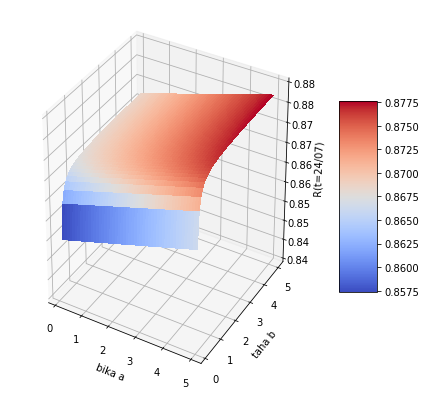

In [7]:
# Variation of R(datyab) with rapport to the prior parameters

datyab = daty_data_mifar

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

# Make data.
X = np.linspace(0.1,5,100)
Y = np.linspace(0.1,5,100)
X, Y = np.meshgrid(X, Y)
Z = func_sh(datyab)(X)*func_sc(datyab)(Y)
W = X*Y
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0.84, 0.88)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set(xlabel ='bika a', ylabel = "taha b", zlabel = 'R(t=24/07)')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig(path_to_save+'Rt247_anta.eps')

plt.show()

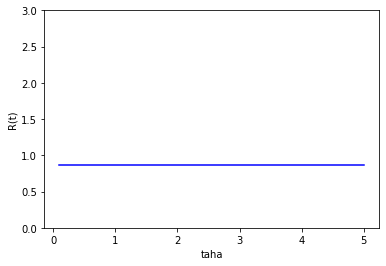

taha* = 1
R(t= 2020-07-24 ) = 0.8687001474299146 = bika*


In [8]:
# R(t) when equality between the prior and the posterior

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, x*funcsh_inv(datyab)(x/func_sc(datyab)(x)), 'blue')

ax.set_ylim(0,3)
ax.set(xlabel ='taha', ylabel = "R(t)")


# show the plot
plt.show()

print('taha* = 1')
print('R(t=',datyab,') =', funcsh_inv(datyab)(1/func_sc(datyab)(1)), '= bika*')


# Fanombanana ny R(t) (estimation of Rt)

In [9]:
#shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh

# Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc


def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[1e-11, 1e+11])

# Rt
def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 75th and 25th percentiles of Rt

def perc75(t):
    return gengamma.ppf(0.75, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc25(t):
    return gengamma.ppf(0.25, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))


def Rtps_sal(t):
  return dIvao['Voatomb'].loc[format_date(t)]/lsi(t)

print("Kajy mivantana ny R hoan'ny", daty_data_mifar, ':', Rtps_sal(daty_data_mifar))

daty_oh1 = datetime.date(2020,7,19)
print("Salan'isa R hoan'ny", daty_oh1, ':', Rt_salan(daty_oh1))
print("Kartily @ 75% R hoan'ny", daty_oh1, ':', perc75(daty_oh1))
print("Kartily @ 25% R hoan'ny", daty_oh1, ':', perc25(daty_oh1))

print("Salan'isa R hoan'ny", daty_data_mifar, ':', Rt_salan(daty_data_mifar))
print("Kartily @ 75% R hoan'ny", daty_data_mifar, ':', perc75(daty_data_mifar))
print("Kartily @ 25% R hoan'ny", daty_data_mifar, ':', perc25(daty_data_mifar))


Kajy mivantana ny R hoan'ny 2020-07-24 : 1.1759242729887411
Salan'isa R hoan'ny 2020-07-19 : 0.982346653481799
Kartily @ 75% R hoan'ny 2020-07-19 : 1.0113264415816359
Kartily @ 25% R hoan'ny 2020-07-19 : 0.9526670326186769
Salan'isa R hoan'ny 2020-07-24 : 0.8687001483379382
Kartily @ 75% R hoan'ny 2020-07-24 : 0.8953845250795911
Kartily @ 25% R hoan'ny 2020-07-24 : 0.8413440823383388


In [10]:
rt_tana_lst = []

daty_oh2 = datetime.date(2020,7,1)
for i in range(24):
  t = daty_oh2 + datetime.timedelta(days = i)
  rt_amboar = Rt_salan(t)
  rt_tana_lst.append((t,Rt_salan(t)))

rt_tana_lst

[(datetime.date(2020, 7, 1), array(1.69338932)),
 (datetime.date(2020, 7, 2), array(1.35665858)),
 (datetime.date(2020, 7, 3), array(1.93213679)),
 (datetime.date(2020, 7, 4), array(2.46179282)),
 (datetime.date(2020, 7, 5), array(2.4655631)),
 (datetime.date(2020, 7, 6), array(3.24022618)),
 (datetime.date(2020, 7, 7), array(2.77225023)),
 (datetime.date(2020, 7, 8), array(1.36195966)),
 (datetime.date(2020, 7, 9), array(1.16903949)),
 (datetime.date(2020, 7, 10), array(1.91183656)),
 (datetime.date(2020, 7, 11), array(2.3646026)),
 (datetime.date(2020, 7, 12), array(1.85616368)),
 (datetime.date(2020, 7, 13), array(1.12268234)),
 (datetime.date(2020, 7, 14), array(1.03308351)),
 (datetime.date(2020, 7, 15), array(1.00274638)),
 (datetime.date(2020, 7, 16), array(1.35793378)),
 (datetime.date(2020, 7, 17), array(1.37468248)),
 (datetime.date(2020, 7, 18), array(1.15336152)),
 (datetime.date(2020, 7, 19), array(0.98234665)),
 (datetime.date(2020, 7, 20), array(0.44051816)),
 (datetime.

In [11]:
# Plotting everything except the first 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -27)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +27)
  data_amboar = [gengamma.rvs( func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1)) for j in range(1000)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


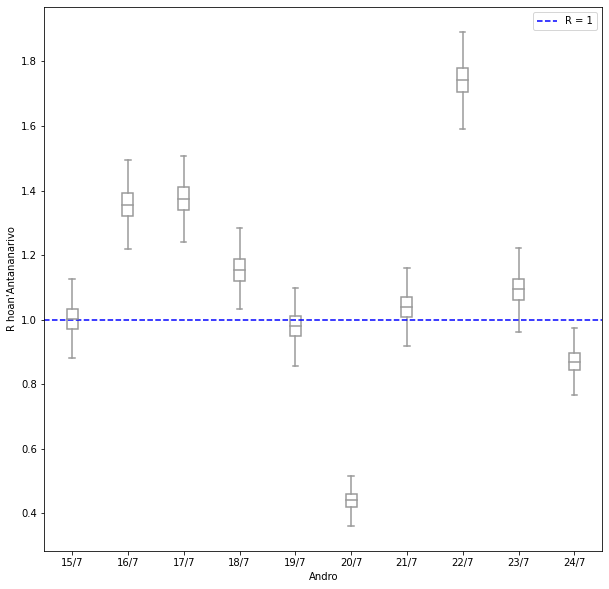

In [12]:
# Plotting the last 10 days


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst, data_Rt_lst, color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'Antananarivo")
ax.legend(loc= 'best')

plt.savefig(path_to_save+'Rt24710_anta.png')
plt.savefig(path_to_save+'Rt24710_anta.eps')
plt.show()

# Jeritodika ny herinandro

In [34]:
daty_ambaj = datetime.date(2020,7,19)
daty_amboj = datetime.date(2020,7,17)

daty_data_mifarj = datetime.date(2020,7,17)

In [35]:
daty_oh1 = daty_ambaj

print("Tombana ambany: R ",daty_oh1,':',  Rt_salan(daty_oh1))
print("75%-kartily R :",':', perc75(daty_oh1))
print("25%-kartily R :", perc25(daty_oh1))

daty_oh2 = daty_amboj

print("Tombana ambony: R", daty_oh2,':', Rt_salan(daty_oh2))
print("75%-kartily R :",':', perc75(daty_oh2))
print("25%-kartily R :", perc25(daty_oh2))


Tombana ambany: R  2020-07-19 : 0.982346653481799
75%-kartily R : : 1.0113264415816359
25%-kartily R : 0.9526670326186769
Tombana ambony: R 2020-07-17 : 1.3746824812777663
75%-kartily R : : 1.4102428347612108
25%-kartily R : 1.338371465430571


### Ambany

In [36]:
# Computing Ivao(daty_mifarj + i) for i in range(1,8)

daty_m1j = daty_data_mifarj + datetime.timedelta(days = 1)

Rt_amba_hitsiny = (Rt_salan(datetime.date(2020,7,20))- Rt_salan(daty_ambaj))/2

#Rt_amba_hitsiny = 0
Rt_vinaj = Rt_salan(daty_ambaj) + Rt_amba_hitsiny

Iv = int(Rt_vinaj*lsi(daty_m1j))

dIvao.loc[pd.to_datetime(daty_m1j)] =[Iv]

for i in range(1,8):
 tj = daty_m1j + datetime.timedelta(days = i)
 Ivv = int(Rt_vinaj*lsi(tj))
 dIvao.loc[pd.to_datetime(tj)] = [Ivv]

In [37]:
Rt_vinaj

0.7114324090311054

In [16]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_j_lst = []

data_baj = []


for i in range(1,8):
  t = daty_data_mifarj + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_j_lst.append(daty)
  data_baj.append(data_amboar)


###Ambony

In [39]:
# Computing Ivao(daty_mifarj + i) for i in range(1,8)

daty_m1j = daty_data_mifarj + datetime.timedelta(days = 1)

Rt_ambo_hitsiny = (Rt_salan(datetime.date(2020,7,22))- Rt_salan(daty_amboj))/2

#Rt_ambo_hitsiny = 0
Rt_vinaj = Rt_salan(daty_amboj) + Rt_ambo_hitsiny

Iv = int(Rt_vinaj*lsi(daty_m1j))

dIvao.loc[pd.to_datetime(daty_m1j)] =[Iv]

for i in range(1,8):
 tj = daty_m1j + datetime.timedelta(days = i)
 Ivv = int(Rt_vinaj*lsi(tj))
 dIvao.loc[pd.to_datetime(tj)] = [Ivv]

In [40]:
Rt_vinaj

1.5585589509938038

In [19]:
# Sampling 

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_j_lst = []

data_boj = []


for i in range(1,8):
  t = daty_data_mifarj + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_j_lst.append(daty)
  data_boj.append(data_amboar)


### Sary

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


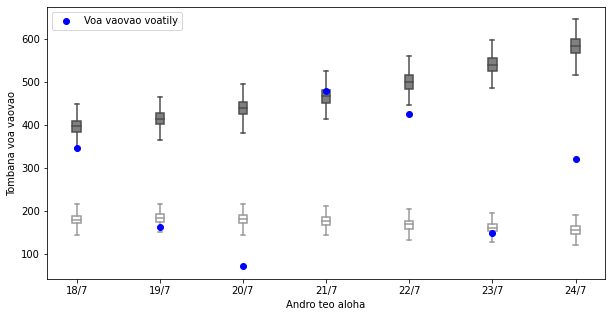

In [22]:
# Plotting the evaluation of the last 7 days

fig, ax = plt.subplots(figsize=(10,5))
box = sns.boxplot(daty_j_lst, data_baj, color='white', width=0.1, showfliers=False, ax=ax)
box = sns.boxplot(daty_j_lst, data_boj, color='grey', width=0.1, showfliers=False, ax=ax)
ax.plot(daty_j_lst, dIvao.loc[pd.to_datetime(daty_m1j):pd.to_datetime(daty_m1j + datetime.timedelta(days = 6))], marker ="o",ls = 'None', color='blue',label="Voa vaovao voatily")
ax.set(xlabel = 'Andro teo aloha', ylabel="Tombana voa vaovao")

plt.legend(loc= 'best')

plt.savefig(path_to_save+'Iv187j_anta.eps')
plt.savefig(path_to_save+'Iv187j_anta.png')

plt.show()

# Ny 7 andro manaraka

In [23]:
# Choice of R(t) for the forecasting

# Dates for which R(t) is minimum and maximum during the last 10 days

daty_amba = datetime.date(2020,7,15)
daty_ambo = datetime.date(2020,7,17)

### Vinavina ambany

In [24]:
# Computing Ivao(daty_mifar + i) for i in range(1,8)

daty_m1 = daty_data_mifar + datetime.timedelta(days = 1)

Iv = int(Rt_salan(daty_amba)*lsi(daty_m1))

dIvao.loc[pd.to_datetime(daty_m1)] =[Iv]

for i in range(1,8):
 errt = daty_m1 + datetime.timedelta(days = i)
 Ivv = int(Rt_salan(daty_amba)*lsi(errt))
 dIvao.loc[pd.to_datetime(errt)] =[Ivv]


In [25]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_hoav_lst = []

data_amba_hoav = []

Ivv_dat = []

for i in range(1,8):
  t = daty_data_mifar + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_hoav_lst.append(daty)
  data_amba_hoav.append(data_amboar)

In [26]:
print('Vinavina ambany')

daty_oh = datetime.date(2020,7,26)

print("Notombanana avy amin'ny R(", daty_amba, ')', Rt_salan(daty_amba)) 
print("Vinavina R hoan'ny", daty_oh, ':', Rt_salan(daty_oh))
print("Vinavina kartily @ 75% R hoan'ny",daty_oh, ':', perc75(daty_oh))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', perc25(daty_oh))
print("Vinavina isan'ny voa vaovao hoan'ny", daty_oh, ':', dIvao['Voatomb'].loc[format_date(daty_oh)])

print("Vinavina kartily @ 75% R hoan'ny", daty_oh, ':', poisson.ppf(0.95, dIvao.loc[format_date(daty_oh)]))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', poisson.ppf(0.25, dIvao.loc[format_date(daty_oh)]))

Vinavina ambany
Notombanana avy amin'ny R( 2020-07-15 ) 1.0027463767544091
Vinavina R hoan'ny 2020-07-26 : 1.001089719747427
Vinavina kartily @ 75% R hoan'ny 2020-07-26 : 1.0293140383362505
Vinavina kartily @ 25% R hoan'ny 2020-07-26 : 0.972214743903576
Vinavina isan'ny voa vaovao hoan'ny 2020-07-26 : 280.0
Vinavina kartily @ 75% R hoan'ny 2020-07-26 : [308.]
Vinavina kartily @ 25% R hoan'ny 2020-07-26 : [269.]


### Vinavina ambony

In [28]:
# Computing Ivao(daty_mifar + i) for i in range(1,8)

daty_m1 = daty_data_mifar + datetime.timedelta(days = 1)

Iv = int(Rt_salan(daty_ambo)*lsi(daty_m1))

dIvao.loc[pd.to_datetime(daty_m1)] =[Iv]

for i in range(1,8):
 errt = daty_m1 + datetime.timedelta(days = i)
 Ivv = int(Rt_salan(daty_ambo)*lsi(errt))
 dIvao.loc[pd.to_datetime(errt)] =[Ivv]


In [29]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_hoav_lst = []

data_ambo_hoav = []

Ivv_dat = []

for i in range(1,8):
  t = daty_data_mifar + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_hoav_lst.append(daty)
  data_ambo_hoav.append(data_amboar)

In [30]:
print('Vinavina ambony')

daty_oh = datetime.date(2020,7,26)

print("Notombanana avy amin'ny R(", daty_ambo, ')', Rt_salan(daty_ambo)) 
print("Vinavina R hoan'ny", daty_oh, ':', Rt_salan(daty_oh))
print("Vinavina kartily @ 75% R hoan'ny",daty_oh, ':', perc75(daty_oh))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', perc25(daty_oh))
print("Vinavina isan'ny voa vaovao hoan'ny", daty_oh, ':', dIvao['Voatomb'].loc[format_date(daty_oh)])

print("Vinavina kartily @ 75% R hoan'ny", daty_oh, ':', poisson.ppf(0.95, dIvao.loc[format_date(daty_oh)]))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', poisson.ppf(0.25, dIvao.loc[format_date(daty_oh)]))

Vinavina ambony
Notombanana avy amin'ny R( 2020-07-17 ) 1.3746824812777663
Vinavina R hoan'ny 2020-07-26 : 1.3736933261128186
Vinavina kartily @ 75% R hoan'ny 2020-07-26 : 1.4067012795708844
Vinavina kartily @ 25% R hoan'ny 2020-07-26 : 1.3400391544750148
Vinavina isan'ny voa vaovao hoan'ny 2020-07-26 : 390.0
Vinavina kartily @ 75% R hoan'ny 2020-07-26 : [423.]
Vinavina kartily @ 25% R hoan'ny 2020-07-26 : [377.]


### Sary

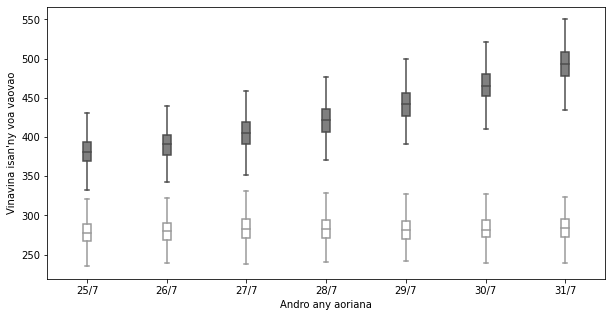

In [32]:
# Plotting boundaries for the next 7 days

fig, ax = plt.subplots(figsize=(10,5))
box = sns.boxplot(daty_hoav_lst, data_amba_hoav, color='white', width=0.1, showfliers=False, ax=ax)
box = sns.boxplot(daty_hoav_lst, data_ambo_hoav, color='grey', width=0.1, showfliers=False, ax=ax)

ax.set_xlabel('Andro any aoriana')
ax.set_ylabel("Vinavina isan'ny voa vaovao")

plt.savefig(path_to_save+'Iv247hoav_anta.eps')
plt.savefig(path_to_save+'Iv247hoav_anta.png')

plt.show()

## Vinavina lavitra 

In [ ]:
# Choice of R(t) for the forecasting

# Dates for which R(t) is minimum and maximum during the last 10 days

daty_amba = datetime.date(2020,6,15)
daty_ambo = datetime.date(2020,6,11)


### Lavitra ambany

In [ ]:
# Computing Ivao(daty_mifar + i) for i in range(1,8)

daty_m1 = daty_data_mifar + datetime.timedelta(days = 1)

Iv = int(Rt_salan(daty_amba)*lsi(daty_m1))

dIvao.loc[pd.to_datetime(daty_m1)] =[Iv]

for i in range(1,200):
 errt = daty_m1 + datetime.timedelta(days = i)
 Ivv = int(Rt_salan(daty_amba)*lsi(errt))
 dIvao.loc[pd.to_datetime(errt)] =[Ivv]


In [ ]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month))

daty_hoav_lst = []

data_amba_hoav = []

Ivv_dat = []

for i in range(1,200):
  t = daty_data_mifar + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_hoav_lst.append(daty)
  data_amba_hoav.append(data_amboar)

In [ ]:
print('Vinavina hafa ambany')

daty_oh = datetime.date(2020,9,4) 

Ireh_mifar = 

print("Notombanana avy amin'ny R(", daty_amba, ')', Rt_salan(daty_amba)) 
print("Vinavina R hoan'ny", daty_oh, ':', Rt_salan(daty_oh))
print("Vinavina kartily @ 75% R hoan'ny",daty_oh, ':', perc75(daty_oh))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', perc25(daty_oh))
print("Vinavina isan'ny voa vaovao hoan'ny", daty_oh, ':', dIvao['Voatomb'].loc[format_date(daty_oh)])

print("Vinavina kartily @ 75% R hoan'ny", daty_oh, ':', poisson.ppf(0.95, dIvao.loc[format_date(daty_oh)]))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', poisson.ppf(0.25, dIvao.loc[format_date(daty_oh)]))

print("Isan'ny voa rehetra hatr@", daty_oh, ':', Ireh_mifar + Ireh(daty_oh,(daty_oh - daty_data_mifar).days))

### Lavitra ambany

In [ ]:
# Computing Ivao(daty_mifar + i) for i in range(1,8)

daty_m1 = daty_data_mifar + datetime.timedelta(days = 1)

Iv = int(Rt_salan(daty_ambo)*lsi(daty_m1))

dIvao.loc[pd.to_datetime(daty_m1)] =[Iv]

for i in range(1,200):
 errt = daty_m1 + datetime.timedelta(days = i)
 Ivv = int(Rt_salan(daty_ambo)*lsi(errt))
 dIvao.loc[pd.to_datetime(errt)] =[Ivv]


In [ ]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month))

daty_hoav_lst = []

data_ambo_hoav = []

Ivv_dat = []

for i in range(1,200):
  t = daty_data_mifar + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_hoav_lst.append(daty)
  data_ambo_hoav.append(data_amboar)

In [ ]:
print('Vinavina ambony')

daty_oh = datetime.date(2020,12,22)

print("Notombanana avy amin'ny R(", daty_ambo, ')', Rt_salan(daty_ambo)) 
print("Vinavina R hoan'ny", daty_oh, ':', Rt_salan(daty_oh))
print("Vinavina kartily @ 75% R hoan'ny",daty_oh, ':', perc75(daty_oh))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', perc25(daty_oh))
print("Vinavina isan'ny voa vaovao hoan'ny", daty_oh, ':', dIvao['Voatomb'].loc[format_date(daty_oh)])

print("Vinavina kartily @ 75% R hoan'ny", daty_oh, ':', poisson.ppf(0.95, dIvao.loc[format_date(daty_oh)]))
print("Vinavina kartily @ 25% R hoan'ny", daty_oh, ':', poisson.ppf(0.25, dIvao.loc[format_date(daty_oh)]))

print("Isan'ny voa rehetra hatr@", daty_oh, ':', Ireh_mifar + Ireh(daty_oh,(daty_oh - daty_data_mifar).days))

## Sary

In [ ]:
# Plotting boundaries for the next 7 days

fig, ax = plt.subplots(figsize=(30,15))
box = sns.boxplot(daty_hoav_lst, data_amba_hoav, color='white', width=0.1, showfliers=False, ax=ax)
box = sns.boxplot(daty_hoav_lst, data_ambo_hoav, color='grey', width=0.1, showfliers=False, ax=ax)

ax.set_xlabel('Andro any aoriana')
ax.set_ylabel("Vinavina isan'ny voa vaovao")

plt.savefig(path_to_save+'Iv167ahoav_ant.eps')
plt.savefig(path_to_save+'Iv167ahoav_ant.png')

plt.show()

In [ ]:
# Plotting boundaries for the next 7 days

fig, ax = plt.subplots(figsize=(10,5))
box = sns.boxplot(daty_hoav_lst[70:80], data_amba_hoav[70:80], color='white', width=0.1, showfliers=False, ax=ax)
box = sns.boxplot(daty_hoav_lst[70:80], data_ambo_hoav[70:80], color='grey', width=0.1, showfliers=False, ax=ax)

ax.set_xlabel('Andro any aoriana')
ax.set_ylabel("Vinavina isan'ny voa vaovao")

plt.savefig(path_to_save+'Iv1677080hoav_ant.eps')
plt.savefig(path_to_save+'Iv1677080hoav_ant.png')

plt.show()